In [5]:
import yaml

In [6]:
import yaml 

with open('cfg.yaml', 'r') as f:
    cfg = yaml.safe_load(f)

print(cfg)

{'data_dir': '../osteo-chestxray/data_1/data'}


# Explore dataset

In [7]:
from torch.utils.data import Dataset
from glob import glob
from PIL import Image
import torch 
import numpy as np 

class OsteoDataset(Dataset):
    def __init__(self, cfg, transform=None):
        self.cfg = cfg 
        self.data_dir = cfg['data_dir']
        self.data_list = glob(self.data_dir + '/*.png')
        self.transform = transform
        
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path = self.data_list[idx]
        img = Image.open(img_path)
        
        if self.transform:
            img = self.transform(img)

        return img 


In [8]:
osteo = OsteoDataset(cfg)

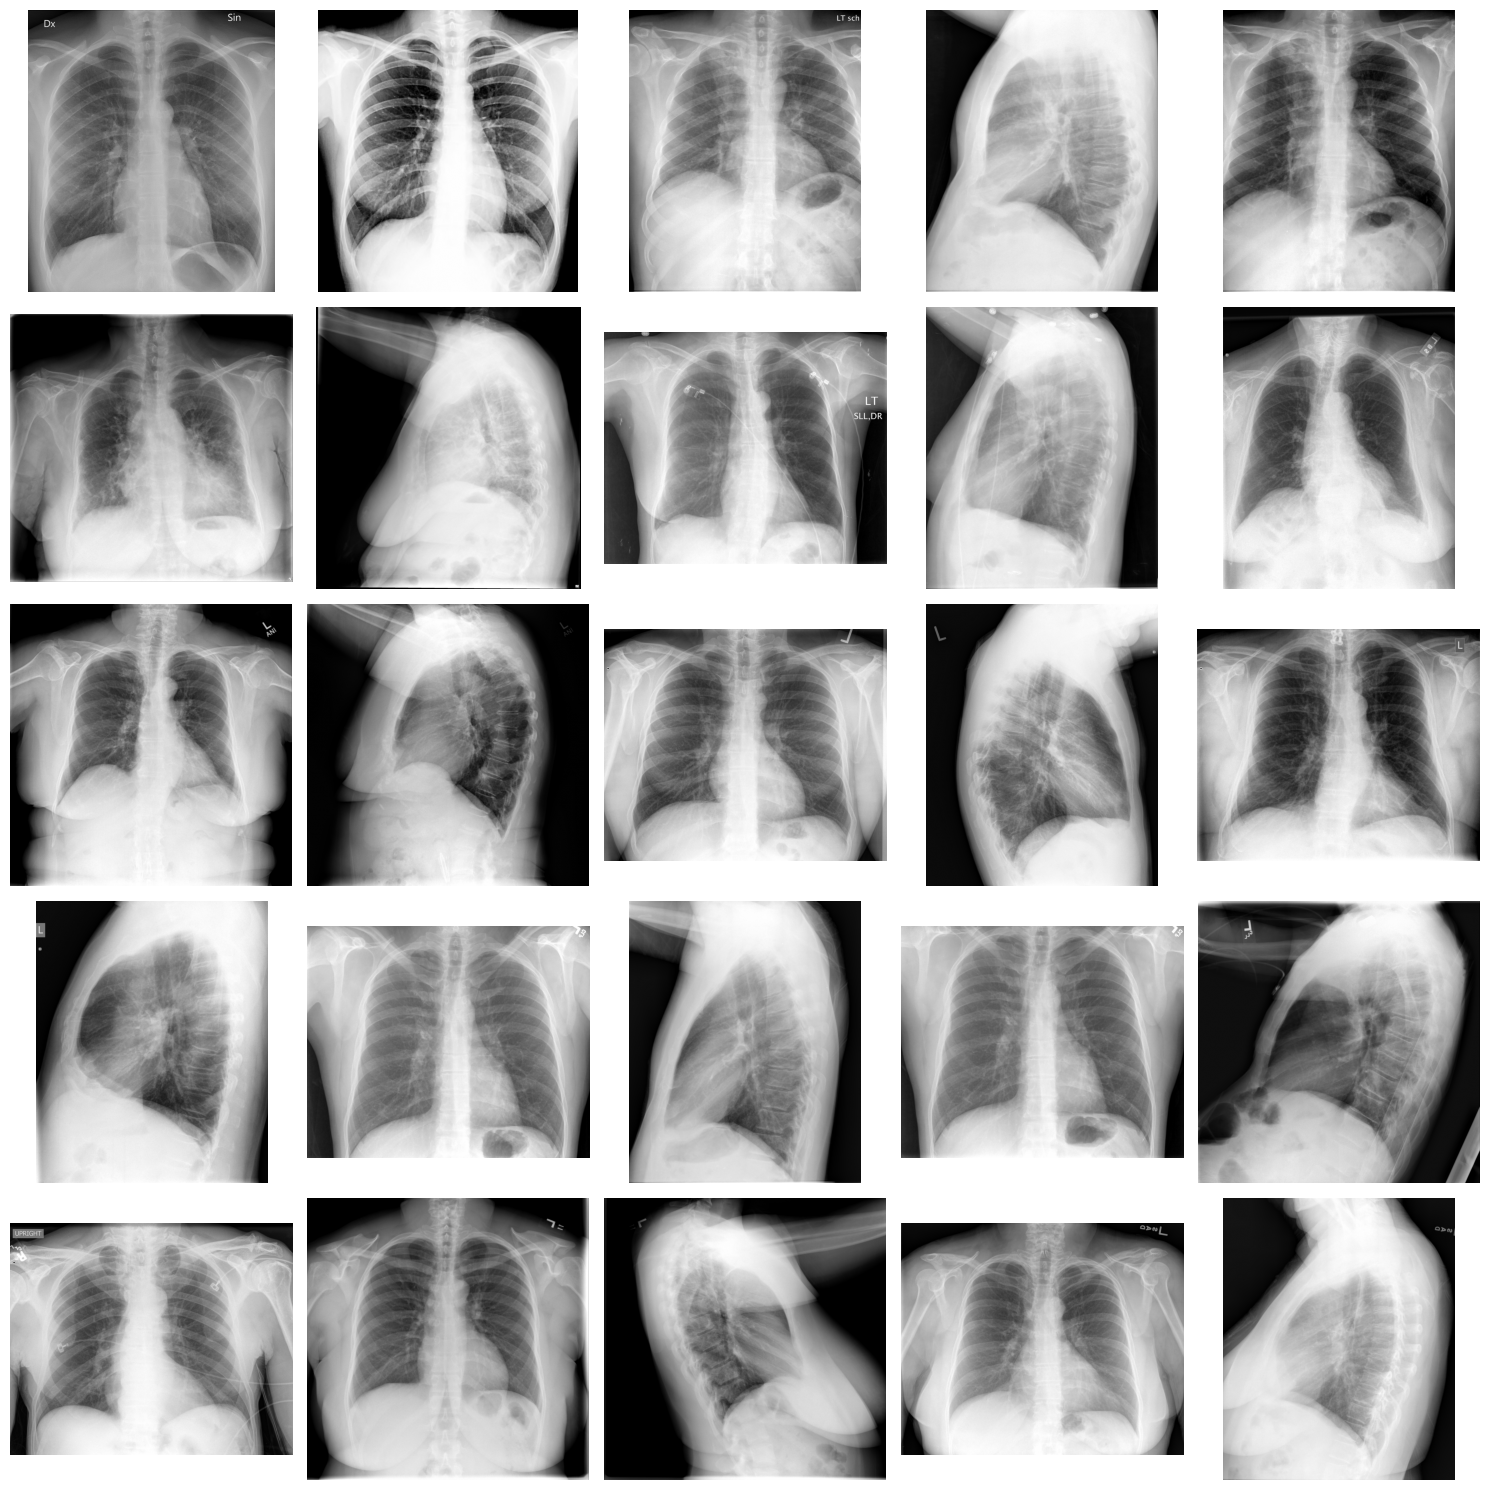

In [9]:
import matplotlib.pyplot as plt 
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        idx = i * 5 + j
        axes[i,j].imshow(osteo[idx], cmap='gray')
        axes[i,j].axis('off')
plt.tight_layout()
plt.show()

#  Building Diffusion Model

## Step 1: Forward process = Noise scheduler 

We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually.

Key Takeaways:

The noise-levels/variances can be pre-computed
There are different types of variance schedules
We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
No model is needed in this forward step

In [10]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [12]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np
import torchvision 
from sklearn.model_selection import train_test_split

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)

    dataset = OsteoDataset(cfg, transform=data_transforms)
    indices = list(range(len(dataset)))
    train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)
    
    
    return torch.utils.data.ConcatDataset([train_dataset, test_dataset])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [27]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

TypeError: 'list' object is not callable